# Introdução à Ciência de Dados - Projeto Parte 2

<p align="justify">
Nessa etapa, iremos escolher uma das colunas do nosso dataset para para fazermos uma regressão baseada nas demais features. Avaliaremos quatro diferentes algoritmos para essa tarefa e utilizaremos o MLFlow para fazer o rastreamento. Adicionalmente, usaremos o Optuna para variar os hiperparâmetros de cada abordagem e escolher o melhor deles.

### Equipe:
> Pedro Henrique Almeida Girão Peixinho (phagp)

> Victor Gabriel de Carvalho (vgc3)

### Tópicos Avançados em Gerenciamento de Dados e Informação IF697 - 2024.1 - Centro de Informáica UFPE

In [1]:
import pandas as pd
import numpy as np

from sklearn.covariance import EllipticEnvelope
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import KNNImputer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt

import logging
import mlflow
import optuna
optuna.logging.set_verbosity(optuna.logging.INFO)
# import autosklearn.regression

tf.random.set_seed(9)
keras.utils.set_random_seed(9)

c:\Victor\UFPE\P9\Tópicos Avançados em Gerenciamento de Dados Informação\Ciencia-de-Dados-Projeto-1\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---

## Pre-Processamento

<p align="justify">
O pré-processamento de dados é uma etapa crítica no desenvolvimento de modelos de aprendizado de máquina, sendo essencial para garantir a qualidade e a robustez das previsões. Este processo envolve várias etapas, cada uma destinada a transformar os dados brutos em um formato adequado para análise e modelagem.

In [2]:
df_cars = pd.read_csv(r'carscraper\cars.csv')
df_cars.head()

,page,car_brand,car_name,car_price,car_km,car_year,car_desc,car_store,car_engine,car_gearbox,car_fuel,car_color
0,https://grupoautonunes.com/estoque/?zero_km=0&...,Fiat,500E,125990.0,7521.0,2022,ICON ELÉTRICO,NaN,Elétrico,Automatico,Elétrico,NaN
1,https://grupoautonunes.com/estoque/?zero_km=0&...,Audi,Q3,128980.0,40000.0,2018,1.4 TFSI AMBIENTE FLEX 4P S TRONIC,NaN,1.4,Automatico,Flex,NaN
2,https://grupoautonunes.com/estoque/?zero_km=0&...,Chevrolet,Onix,70990.0,40686.0,2023,1.0 FLEX LT MANUAL,NaN,1.0,Manual,Flex,NaN
3,https://grupoautonunes.com/estoque/?zero_km=0&...,Chevrolet,Onix,79990.0,57643.0,2022,1.0 TURBO FLEX PLUS LTZ AUTOMÁTICO,NaN,1.0 Turbo,Automatico,Flex,NaN
4,https://grupoautonunes.com/estoque/?zero_km=0&...,Volkswagen,Saveiro,77990.0,29000.0,2023,1.6 MSI TRENDLINE CS 8V FLEX 2P MANUAL,NaN,1.6,Manual,Flex,NaN


<p align="justify">
O dataset é composto originalmente por 1124 amostras de carros usados presentes na região metropolitana do Recife. Cada amostra possui até 12 atributos.

- page: URL da página de onde foi tirada a amostra.
- car_brand: Marca do veículo.
- car_name: Nome do veículo
- car_price: Preço do carro no momento da coleta.
- car_km: Quilometragem total do carro.
- car_year: Ano do modelo.
- car_desc: Descrição e informações gerais do veíclulo.
- car_store: Loja onde o carro está localizado.
- car_engine: Tamanho/Tipo do motor.
- car_gearbox: Tipo de embreagem.
- car_fuel: Tipo de combustível.
- car_color: Cor do automível.

<p align="justify">
Vale ressaltar que, natualmente, nem todos os campos puderam ser preenchidos para todas as amostras e aguns dos campos não possuem relevância estatística para a modelagem. Isso será tratato a seguir.

In [3]:
df_cars.shape

(1124, 12)

<p align="justify">
Como dito acima, iremos remover as colunas "page" e "car_desc", já que não ajudarão no treinamento ("car_desc" foi já separado em outras colunas durante a elaboração do dataset). Além das colunas irrelevantes, será feita a remoção de linhas duplicadas, caso existam.

In [4]:
df_cars.drop(['page', 'car_desc'], axis=1, inplace=True)
df_cars.drop_duplicates(inplace=True)

df_cars.head()

,car_brand,car_name,car_price,car_km,car_year,car_store,car_engine,car_gearbox,car_fuel,car_color
0,Fiat,500E,125990.0,7521.0,2022,NaN,Elétrico,Automatico,Elétrico,NaN
1,Audi,Q3,128980.0,40000.0,2018,NaN,1.4,Automatico,Flex,NaN
2,Chevrolet,Onix,70990.0,40686.0,2023,NaN,1.0,Manual,Flex,NaN
3,Chevrolet,Onix,79990.0,57643.0,2022,NaN,1.0 Turbo,Automatico,Flex,NaN
4,Volkswagen,Saveiro,77990.0,29000.0,2023,NaN,1.6,Manual,Flex,NaN


In [5]:
df_cars.dtypes

car_brand       object
car_name        object
car_price      float64
car_km         float64
car_year         int64
car_store       object
car_engine      object
car_gearbox     object
car_fuel        object
car_color       object
dtype: object

<p align="justify">
Mudaremos o tipo dos dados de "object" para "category". Isso nos permitirá utilizar alguns métodos ja presenes no dataframe.

In [6]:
df_cars_cat = df_cars.copy()
object_columns = df_cars.select_dtypes(['object']).columns
df_cars_cat[object_columns] = df_cars[object_columns].astype('category')

df_cars_cat.dtypes

car_brand      category
car_name       category
car_price       float64
car_km          float64
car_year          int64
car_store      category
car_engine     category
car_gearbox    category
car_fuel       category
car_color      category
dtype: object

<p align="justify">
Abaixo, transformaremos os valores categóricos em valores numérios, para possibilitar a análise pelos modelos.

In [7]:
df_cars_codes = df_cars_cat.copy()
category_columns = df_cars_cat.select_dtypes(['category']).columns
df_cars_codes[category_columns] = df_cars_cat[category_columns].apply(lambda x: x.cat.codes.replace(-1, np.nan))

df_cars_codes.head()

,car_brand,car_name,car_price,car_km,car_year,car_store,car_engine,car_gearbox,car_fuel,car_color
0,8,9,125990.0,7521.0,2022,NaN,29,0,1.0,NaN
1,1,108,128980.0,40000.0,2018,NaN,6,0,2.0,NaN
2,6,96,70990.0,40686.0,2023,NaN,0,1,2.0,NaN
3,6,96,79990.0,57643.0,2022,NaN,1,0,2.0,NaN
4,29,122,77990.0,29000.0,2023,NaN,10,1,2.0,NaN


In [8]:
df_cars_codes.isnull().sum()

car_brand         0
car_name          0
car_price         0
car_km            0
car_year          0
car_store      1095
car_engine        0
car_gearbox       0
car_fuel         48
car_color       986
dtype: int64

Iremos remover as colunas com mais de 70% dos valores ausentes. Nesse cenário, métodos de adição de valores seriam inviáveis, pois a quantidade de faltas é muito grande.

In [9]:
df_cars_codes.dropna(thresh=0.7*len(df_cars_codes), axis=1, inplace=True)
df_cars_codes.head()

,car_brand,car_name,car_price,car_km,car_year,car_engine,car_gearbox,car_fuel
0,8,9,125990.0,7521.0,2022,29,0,1.0
1,1,108,128980.0,40000.0,2018,6,0,2.0
2,6,96,70990.0,40686.0,2023,0,1,2.0
3,6,96,79990.0,57643.0,2022,1,0,2.0
4,29,122,77990.0,29000.0,2023,10,1,2.0


In [10]:
df_cars_codes.dtypes

car_brand         int8
car_name         int16
car_price      float64
car_km         float64
car_year         int64
car_engine        int8
car_gearbox       int8
car_fuel       float64
dtype: object

<p align="justify">
A partir daqui, devemos dividir o dataset em treinamento, validação e teste. Isso é necessário porquê não devemos deixar os valores de teste interferirem no treinamento e vice-versa. Logo, as operações de adição de dados e normalização devem ser feitas de forma independente em cada subset. Devido ao tamanho pequeno do dataset, faremos uma divisão de 80% para treinamento, 10% para validação e 10% para teste.

In [11]:
df_train, df_test = train_test_split(df_cars_codes, test_size=0.2, random_state=9)
df_test, df_val = train_test_split(df_test, test_size=0.5, random_state=9)

print(df_train.shape, df_val.shape, df_test.shape)

(882, 8) (111, 8) (110, 8)


<p align="justify">
A parte de normalização e inputação será feita utilizando como base exclusivamente o dataset de treinamento. Esses mesmos valores serão utilizados, novamente, nos sets de validação e teste, ja que, em uma situação real, apenas teríamos acesso ao treinamento.

In [12]:
df_train_median_fill = df_train.copy()

car_fuel_train_fill = df_train_median_fill['car_fuel'].median()

df_train_median_fill['car_fuel'] = df_train_median_fill['car_fuel'].fillna(car_fuel_train_fill)
df_train_median_fill.isnull().sum()

car_brand      0
car_name       0
car_price      0
car_km         0
car_year       0
car_engine     0
car_gearbox    0
car_fuel       0
dtype: int64

<p align="justify">
De forma análoga, apenas seria possível tratar os outliers no dataset de treinamento.

In [13]:
df_train_median_fill_ee = df_train_median_fill.copy()

detector = EllipticEnvelope(contamination=0.01, support_fraction=0.85)
detector.fit(df_train_median_fill_ee)

scores = detector.predict(df_train_median_fill_ee)
df_train_median_fill_ee['outlier'] = scores

df_train_median_fill_ee['outlier'] = df_train_median_fill_ee['outlier'].astype('int')

df_train_median_fill_ee.head()

df_train_median_fill_ee = df_train_median_fill_ee[df_train_median_fill_ee['outlier'] != -1]
df_train_median_fill_ee.drop('outlier', axis=1, inplace=True)
df_train_median_fill_ee.count()

car_brand      873
car_name       873
car_price      873
car_km         873
car_year       873
car_engine     873
car_gearbox    873
car_fuel       873
dtype: int64

In [14]:
min_max_scaler = MinMaxScaler()
df_train_median_fill_ee_norm = min_max_scaler.fit_transform(df_train_median_fill_ee)
df_train_median_fill_ee_norm = pd.DataFrame(df_train_median_fill_ee_norm, columns=df_train_median_fill_ee.columns)

print(min_max_scaler.data_max_)
print(min_max_scaler.data_min_)

[3.000e+01 1.570e+02 6.499e+05 6.540e+05 2.025e+03 2.900e+01 1.000e+00
 5.000e+00]
[1.000e+00 0.000e+00 2.499e+04 0.000e+00 2.005e+03 0.000e+00 0.000e+00
 0.000e+00]


In [15]:
X_train = df_train_median_fill_ee_norm.drop('car_price', axis=1)
y_train = df_train_median_fill_ee_norm['car_price']

X_train.shape, y_train.shape

((873, 7), (873,))

---

In [16]:
df_val_median_fill = df_val.copy()

df_val_median_fill['car_fuel'] = df_val_median_fill['car_fuel'].fillna(car_fuel_train_fill)
df_val_median_fill.isnull().sum()

car_brand      0
car_name       0
car_price      0
car_km         0
car_year       0
car_engine     0
car_gearbox    0
car_fuel       0
dtype: int64

In [17]:
df_val_median_fill_norm = min_max_scaler.transform(df_val_median_fill)
df_val_median_fill_norm = pd.DataFrame(df_val_median_fill_norm, columns=df_val_median_fill.columns)

X_val = df_val_median_fill_norm.drop('car_price', axis=1)
y_val = df_val_median_fill_norm['car_price']

X_val.shape, y_val.shape

((111, 7), (111,))

In [18]:
df_test_median_fill = df_test.copy()

df_test_median_fill['car_fuel'] = df_test_median_fill['car_fuel'].fillna(car_fuel_train_fill)
df_test_median_fill.isnull().sum()

car_brand      0
car_name       0
car_price      0
car_km         0
car_year       0
car_engine     0
car_gearbox    0
car_fuel       0
dtype: int64

In [19]:
df_test_median_fill_norm = min_max_scaler.transform(df_test_median_fill)
df_test_median_fill_norm = pd.DataFrame(df_test_median_fill_norm, columns=df_test_median_fill.columns)

X_test = df_test_median_fill_norm.drop('car_price', axis=1)
y_test = df_test_median_fill_norm['car_price']

X_test.shape, y_test.shape

((110, 7), (110,))

---

## Modelos de Regressão

<p align="justify">
Os modelos de regressão são uma classe fundamental de algoritmos de aprendizado de máquina. Diferente dos modelos de classificação, que preveem categorias discretas, os modelos de regressão são empregados para tarefas onde a saída é uma variável contínua, como prever preços, temperaturas, ou outras medidas quantitativas.

<p align="justify">
A escolha do modelo apropriado depende das características do conjunto de dados e da natureza da relação entre as variáveis independentes e dependentes. Nessa etapa do projeto, avaliaremos os modelos de Linar Regression, Random Forest Regressor, Gradient Boosting Regressor e Neural Networks. Cada abordagem contará com a variação e avaliação de multiplos conjuntos de inicializações e parâmetros, fiscalizados pelo MLFlow e selecionados pelo Optuna.

<p align="justify">
Para todos os modelos, inicialmente veremos o resultado na inicialização base (default) das bibliotecas. Após isso, uma bateria de testes será feita em cada um. A métrica de avaliação majoritária será o R2 Score, amplamente utilizado em abordagens de regressão, outras métricas serão empregadas posteriormente.

### Configurando o MLflow

<p align="justify">
Após rodar a célula abaixo, execute o comando "mlfow ui" no seu terminal e abra o link "http://localhost:5000". É lá onde aparecerão o log de cada execução.

In [21]:
mlflow.set_tracking_uri("http://localhost:5000")

---

### Linear Regression

<p align="justify">
A regressão linear é um método estatístico simples e amplamente utilizado para modelar a relação entre uma variável dependente contínua e uma ou mais variáveis independentes. O modelo assume que essa relação pode ser descrita por uma linha reta (ou hiperplano, em caso de regressão de multiplas variáveis). A regressão linear é popular devido à sua interpretabilidade e eficiência computacional, tornando-se uma escolha padrão para problemas de regressão simples e de pequena escala. No entanto, sua simplicidade pode ser uma limitação em casos onde a relação entre as variáveis é não linear ou complexa.

In [22]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
lin_reg.score(X_test, y_test)

0.48044819748746637

In [23]:
lin_reg_best_pred = lin_reg.predict(X_test)
lin_reg_best_r2 = lin_reg.score(X_test, y_test)
lin_reg_best_mse = np.mean((lin_reg_best_pred - y_test)**2)
lin_reg_best_mae = np.mean(np.abs(lin_reg_best_pred - y_test))

print(f'Linear Regression R2: {lin_reg_best_r2}')
print(f'Linear Regression MSE: {lin_reg_best_mse}')
print(f'Linear Regression MAE: {lin_reg_best_mae}')

Linear Regression R2: 0.48044819748746637
Linear Regression MSE: 0.011984392284794903
Linear Regression MAE: 0.058890123714717586


---

### Random Forest Regressor

<p align="justify">
O Random Forest Regressor é um poderoso algoritmo de aprendizado de máquina baseado em ensembles (método de bagging) que utiliza múltiplas árvores de decisão para melhorar a precisão preditiva e controlar o overfitting. Cada árvore no conjunto é treinada com um subconjunto aleatório dos dados e das características, e as previsões são feitas pela média das previsões individuais das árvores. O Random Forest Regressor é eficaz em capturar relações complexas e não lineares nos dados e lida bem com grandes volumes de dados.

In [24]:
rf_reg = RandomForestRegressor(
    n_estimators=100, criterion='squared_error', min_samples_split=2, min_samples_leaf=1, 
    random_state=9
)
rf_reg.fit(X_train, y_train)
rf_reg.score(X_test, y_test)

0.8690817091809793

<p align="justify">
O código abaixo faz o ajuste de hiperparâmetros através do Optuna para o RandomForestRegressor. Escolhemos variar os valores de n_estimators, criterion, min_samples_split e min_samples_leaf, por serem considerados uns dos mais impactantes na performance desse tipo de regressor.

In [25]:
def objective_rf(trial):
    with mlflow.start_run(run_name="Random Forest"):
        n_estimators = trial.suggest_int('n_estimators', 20, 500)
        criterion = trial.suggest_categorical('criterion', ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'])
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        
        rf_reg_obj = RandomForestRegressor(
            n_estimators=n_estimators, criterion=criterion, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, 
            random_state=9
        )
        
        rf_reg_obj.fit(X_train, y_train)

        mlflow.log_param("model_type", "Random Forest")
        mlflow.log_metric("R2", rf_reg_obj.score(X_test, y_test))
        for param in trial.params:
            mlflow.log_param(param, trial.params[param])
        mlflow.sklearn.log_model(rf_reg_obj, "model")

    return rf_reg_obj.score(X_test, y_test)

In [26]:
rf_study = optuna.create_study( study_name="Study for random forest regressor", direction="maximize")
rf_study.optimize(objective_rf, n_trials=50)
print(f'\nBest trial: {rf_study.best_trial}')

[I 2024-07-11 23:27:11,318] A new study created in memory with name: Study for random forest regressor
[I 2024-07-11 23:27:17,738] Trial 0 finished with value: 0.8031185974977123 and parameters: {'n_estimators': 161, 'criterion': 'squared_error', 'min_samples_split': 9, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8031185974977123.
[I 2024-07-11 23:27:20,703] Trial 1 finished with value: 0.8082467568922567 and parameters: {'n_estimators': 283, 'criterion': 'squared_error', 'min_samples_split': 7, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.8082467568922567.
[I 2024-07-11 23:27:23,741] Trial 2 finished with value: 0.8161236159106762 and parameters: {'n_estimators': 348, 'criterion': 'friedman_mse', 'min_samples_split': 9, 'min_samples_leaf': 7}. Best is trial 2 with value: 0.8161236159106762.
[I 2024-07-11 23:27:26,562] Trial 3 finished with value: 0.8082717258028089 and parameters: {'n_estimators': 217, 'criterion': 'friedman_mse', 'min_samples_split': 4, 'min_sampl


Best trial: FrozenTrial(number=32, state=1, values=[0.8739712083437302], datetime_start=datetime.datetime(2024, 7, 11, 23, 28, 54, 777140), datetime_complete=datetime.datetime(2024, 7, 11, 23, 28, 57, 564639), params={'n_estimators': 64, 'criterion': 'poisson', 'min_samples_split': 2, 'min_samples_leaf': 1}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=20, step=1), 'criterion': CategoricalDistribution(choices=('squared_error', 'absolute_error', 'friedman_mse', 'poisson')), 'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=10, log=False, low=1, step=1)}, trial_id=32, value=None)


In [27]:
rf_study.best_trial.params

rf_reg_best = RandomForestRegressor(
    n_estimators=rf_study.best_params['n_estimators'], criterion=rf_study.best_params['criterion'], 
    min_samples_split=rf_study.best_params['min_samples_split'], min_samples_leaf=rf_study.best_params['min_samples_leaf'], 
    random_state=9
)
rf_reg_best.fit(X_train, y_train)
rf_reg_best_pred = rf_reg_best.predict(X_test)

rf_reg_best_r2 = rf_reg_best.score(X_test, y_test)
rf_reg_best_mse = np.mean((rf_reg_best_pred - y_test)**2)
rf_reg_best_mae = np.mean(np.abs(rf_reg_best_pred - y_test))

print(f'Random Forest R2: {rf_reg_best_r2}')
print(f'Random Forest MSE: {rf_reg_best_mse}')
print(f'Random Forest MAE: {rf_reg_best_mae}')

Random Forest R2: 0.8739712083437302
Random Forest MSE: 0.0029070796618995225
Random Forest MAE: 0.025354696606614373


---

### Gradient Boosting Regressor

<p align="justify">
O Gradient Boosting Regressor é uma técnica avançada de ensemble que combina múltiplos modelos fracos para criar um modelo forte. Ele trabalha treinando sequencialmente cada novo modelo para corrigir os erros residuais dos modelos anteriores, otimizando iterativamente a função de custo através do gradiente descendente. O Gradient Boosting é altamente flexível e pode modelar relações complexas e não lineares entre as variáveis.  É amplamente utilizado em competições de ciência de dados devido à sua alta performance.

In [28]:
gb_reg = GradientBoostingRegressor(
    loss='squared_error', learning_rate=0.1, n_estimators=100, criterion='friedman_mse',
    random_state=9
)
gb_reg.fit(X_train, y_train)
gb_reg.score(X_test, y_test)

0.8655316624632208

<p align="justify">
O código abaixo faz o ajuste de hiperparâmetros através do Optuna para o GradientBoostingRegressor. Escolhemos variar os valores de loss, learning_rate, n_estimators e criterion, por serem considerados uns dos mais impactantes na performance desse tipo de regressor.

In [29]:
def objective_gb(trial):
    with mlflow.start_run(run_name="Gradient Boosting"):
        loss = trial.suggest_categorical('loss', ['squared_error', 'absolute_error', 'huber', 'quantile'])
        learning_rate = trial.suggest_float('learning_rate', 0.05, 0.5)
        n_estimators = trial.suggest_int('n_estimators', 20, 500)
        criterion = trial.suggest_categorical('criterion', ['friedman_mse', 'squared_error'])
        
        gb_reg_obj = GradientBoostingRegressor(
            loss=loss, learning_rate=learning_rate, n_estimators=n_estimators, criterion=criterion, 
            random_state=9
        )
        
        gb_reg_obj.fit(X_train, y_train)

        mlflow.log_param("model_type", "Gradient Boosting")
        mlflow.log_metric("R2", gb_reg_obj.score(X_test, y_test))
        for param in trial.params:
            mlflow.log_param(param, trial.params[param])
        mlflow.sklearn.log_model(gb_reg_obj, "model")

    return gb_reg_obj.score(X_test, y_test)

In [30]:
gb_study = optuna.create_study( study_name="Study for gradient boosting regressor", direction="maximize")
gb_study.optimize(objective_gb, n_trials=50)
print(f'\nBest trial: {gb_study.best_trial}')

[I 2024-07-11 23:29:47,422] A new study created in memory with name: Study for gradient boosting regressor
[I 2024-07-11 23:29:49,956] Trial 0 finished with value: 0.8451046436443369 and parameters: {'loss': 'squared_error', 'learning_rate': 0.2745759805765313, 'n_estimators': 24, 'criterion': 'friedman_mse'}. Best is trial 0 with value: 0.8451046436443369.
[I 2024-07-11 23:29:52,810] Trial 1 finished with value: 0.6981173663414524 and parameters: {'loss': 'absolute_error', 'learning_rate': 0.31113507560082354, 'n_estimators': 176, 'criterion': 'friedman_mse'}. Best is trial 0 with value: 0.8451046436443369.
[I 2024-07-11 23:29:56,002] Trial 2 finished with value: 0.7990989140302552 and parameters: {'loss': 'huber', 'learning_rate': 0.08416013755437057, 'n_estimators': 240, 'criterion': 'friedman_mse'}. Best is trial 0 with value: 0.8451046436443369.
[I 2024-07-11 23:29:58,895] Trial 3 finished with value: 0.8908495956995311 and parameters: {'loss': 'squared_error', 'learning_rate': 0.


Best trial: FrozenTrial(number=36, state=1, values=[0.9408167576832518], datetime_start=datetime.datetime(2024, 7, 11, 23, 31, 30, 981986), datetime_complete=datetime.datetime(2024, 7, 11, 23, 31, 33, 721933), params={'loss': 'squared_error', 'learning_rate': 0.4653490811715117, 'n_estimators': 216, 'criterion': 'squared_error'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'loss': CategoricalDistribution(choices=('squared_error', 'absolute_error', 'huber', 'quantile')), 'learning_rate': FloatDistribution(high=0.5, log=False, low=0.05, step=None), 'n_estimators': IntDistribution(high=500, log=False, low=20, step=1), 'criterion': CategoricalDistribution(choices=('friedman_mse', 'squared_error'))}, trial_id=36, value=None)


In [31]:
gb_params = gb_study.best_trial.params

gb_reg_best = GradientBoostingRegressor(
    loss=gb_params['loss'], learning_rate=gb_params['learning_rate'], n_estimators=gb_params['n_estimators'], criterion=gb_params['criterion'],
    random_state=9
)
gb_reg_best.fit(X_train, y_train)
gb_reg_best_pred = gb_reg_best.predict(X_test)

gb_reg_best_r2 = gb_reg_best.score(X_test, y_test)
gb_reg_best_mse = np.mean((gb_reg_best_pred - y_test)**2)
gb_reg_best_mae = np.mean(np.abs(gb_reg_best_pred - y_test))

print(f'Gradient Boosting R2: {gb_reg_best_r2}')
print(f'Gradient Boosting MSE: {gb_reg_best_mse}')
print(f'Gradient Boosting MAE: {gb_reg_best_mae}')

Gradient Boosting R2: 0.9408167576832518
Gradient Boosting MSE: 0.0013651674177241919
Gradient Boosting MAE: 0.02189676612712647


---

### Artificial Neural Network

<p align="justify">
Redes neurais para regressão utilizam a arquitetura de camadas densamente conectadas para modelar relações complexas entre variáveis de entrada e uma variável de saída contínua. Cada camada de neurônios aplica uma transformação linear seguida de uma função de ativação não linear, permitindo que a rede capture padrões complexos nos dados. No entanto, apesar de sua notável performance e aplicabilidade, elas requerem uma grande quantidade de dados para treinar de forma eficaz e são mais propensas a overfitting.

In [32]:
nn_reg = tf.keras.Sequential([
    keras.Input(shape=(X_train.shape[1],)),
    layers.Dense(16, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1),
])

optimizer = tf.keras.optimizers.Adam(0.001)
nn_reg.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'r2_score'])

nn_reg.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,217 (4.75 KB)

 Trainable params: 1,217 (4.75 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

nn_reg.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stop])

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0165 - mae: 0.0716 - r2_score: -0.0620 - val_loss: 0.0258 - val_mae: 0.0800 - val_r2_score: 0.3286
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0099 - mae: 0.0566 - r2_score: 0.3524 - val_loss: 0.0251 - val_mae: 0.0751 - val_r2_score: 0.3457
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0091 - mae: 0.0521 - r2_score: 0.4056 - val_loss: 0.0237 - val_mae: 0.0768 - val_r2_score: 0.3823
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0087 - mae: 0.0512 - r2_score: 0.4273 - val_loss: 0.0227 - val_mae: 0.0746 - val_r2_score: 0.4078
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0083 - mae: 0.0493 - r2_score: 0.4574 - val_loss: 0.0219 - val_mae: 0.0724 - val_r2_score: 0.4299
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0078 - mae: 0.0472 - r2_score: 0.4862 - val_loss: 0.0209 - val_mae: 0.0713 - val_r2_score: 0.4565
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

In [34]:
nn_reg.evaluate(X_test, y_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0067 - mae: 0.0392 - r2_score: 0.7298 


[0.007201795000582933, 0.04257042706012726, 0.6877851486206055]

<p align="justify">
O código abaixo faz o ajuste de hiperparâmetros através do Optuna para o Neural Network Regressor. Escolhemos variar os valores de n_layers, weight_decay, n_units e activation, por serem considerados uns dos mais impactantes na performance desse tipo de regressor.

In [35]:
def create_model(trial):
    n_layers = trial.suggest_int('n_layers', 1, 5)
    weight_decay = trial.suggest_float("weight_decay", 1e-10, 1e-3, log=True)
    
    model = tf.keras.Sequential()
    model.add(keras.Input(shape=(X_train.shape[1],)))
    
    for i in range(n_layers):
        n_units = trial.suggest_int(f'n_units_{i}', 4, 128)
        activation = trial.suggest_categorical(f'activation_{i}', ['relu', 'tanh', 'sigmoid', 'linear'])
        
        model.add(
            layers.Dense(
                n_units, activation=activation, kernel_regularizer=keras.regularizers.l2(weight_decay)
            )
        )
    
    model.add(layers.Dense(1))
    
    return model

def create_optimizer(trial):
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    optimizer = tf.keras.optimizers.Adam(lr)
    
    return optimizer

In [36]:
def objective_nn(trial):
    with mlflow.start_run(run_name="Artificial Neural Network"):
        model = create_model(trial)
        optimizer = create_optimizer(trial)
        
        model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'r2_score'])
        
        early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
        model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stop], verbose=0)

        mlflow.log_param("model_type", "Artificial Neural Network")
        mlflow.log_metric("R2", model.evaluate(X_test, y_test, verbose=0)[2])
        for param in trial.params:
            mlflow.log_param(param, trial.params[param])
        mlflow.keras.log_model(model, "model")
    
    return model.evaluate(X_test, y_test, verbose=0)[2]

In [37]:
study = optuna.create_study( study_name="Study for neural network regressor", direction="maximize")
study.optimize(objective_nn, n_trials=50)
print(study.best_trial)

[I 2024-07-11 23:32:17,941] A new study created in memory with name: Study for neural network regressor
2024/07/11 23:32:25 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
[I 2024-07-11 23:32:30,645] Trial 0 finished with value: 0.5147924423217773 and parameters: {'n_layers': 3, 'weight_decay': 1.0407596989508106e-10, 'n_units_0': 17, 'activation_0': 'relu', 'n_units_1': 126, 'activation_1': 'sigmoid', 'n_units_2': 65, 'activation_2': 'tanh', 'lr': 0.00011196940292065177}. Best is trial 0 with value: 0.5147924423217773.
2024/07/11 23:32:38 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
[I 2024-07-11 23:32:43,561] Trial 1 finished with value: 0.47421908378601074 and parameters: {'n_layers': 4, 'weight_decay': 3.123431953368961e-06, 'n_units_0': 58, 'activation_0': 'linear', 'n_units_1': 50, 'activation_1': 'linear', 'n_units_2': 50, 'activation_2': 'tanh', 'n_units_3': 127, 'activation_3': 'sigmoid'

FrozenTrial(number=32, state=1, values=[0.7974918484687805], datetime_start=datetime.datetime(2024, 7, 11, 23, 37, 43, 611518), datetime_complete=datetime.datetime(2024, 7, 11, 23, 37, 54, 361087), params={'n_layers': 4, 'weight_decay': 6.73220761902422e-10, 'n_units_0': 121, 'activation_0': 'linear', 'n_units_1': 55, 'activation_1': 'relu', 'n_units_2': 66, 'activation_2': 'relu', 'n_units_3': 63, 'activation_3': 'sigmoid', 'lr': 0.0007485729150794295}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_layers': IntDistribution(high=5, log=False, low=1, step=1), 'weight_decay': FloatDistribution(high=0.001, log=True, low=1e-10, step=None), 'n_units_0': IntDistribution(high=128, log=False, low=4, step=1), 'activation_0': CategoricalDistribution(choices=('relu', 'tanh', 'sigmoid', 'linear')), 'n_units_1': IntDistribution(high=128, log=False, low=4, step=1), 'activation_1': CategoricalDistribution(choices=('relu', 'tanh', 'sigmoid', 'linear')), 'n_units_2': IntDist

In [39]:
nn_params = study.best_trial.params

nn_reg_best = create_model(study.best_trial)
nn_reg_best.compile(loss='mse', optimizer=create_optimizer(study.best_trial), metrics=['mae', 'r2_score'])
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
nn_reg_best.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stop])

nn_best_pred = nn_reg_best.predict(X_test)

eval_metrics = nn_reg_best.evaluate(X_test, y_test)
nn_best_r2 = eval_metrics[2]
nn_best_mse = eval_metrics[0]
nn_best_mae = eval_metrics[1]

print(f'Neural Network R2: {nn_best_r2}')
print(f'Neural Network MSE: {nn_best_mse}')
print(f'Neural Network MAE: {nn_best_mae}')

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0515 - mae: 0.1697 - r2_score: -2.2973 - val_loss: 0.0319 - val_mae: 0.0732 - val_r2_score: 0.1700
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0100 - mae: 0.0531 - r2_score: 0.3481 - val_loss: 0.0232 - val_mae: 0.0785 - val_r2_score: 0.3970
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0085 - mae: 0.0528 - r2_score: 0.4385 - val_loss: 0.0218 - val_mae: 0.0733 - val_r2_score: 0.4313
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0076 - mae: 0.0489 - r2_score: 0.5011 - val_loss: 0.0199 - val_mae: 0.0733 - val_r2_score: 0.4808
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069 - mae: 0.0477 - r2_score: 0.5410 - val_loss: 0.0180 - val_mae: 0.0718 - val_r2_score: 0.5308
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0063 - mae: 0.0460 - r2_score: 0.5791 - val_loss: 0.0161 - val_mae: 0.0696 - val_r2_score: 0.5807
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

---

## Avaliação e Comparações

<p align="justify">
A avaliação de modelos de aprendizado de máquina é uma etapa crucial para determinar a eficácia e a robustez das previsões. Nesta seção, apresentamos a análise detalhada dos modelos de regressão desenvolvidos, utilizando métricas de desempenho e gráficos que ilustram a comparação entre os modelos em termos de acurácia e erros.

<p align="justify">
Para avaliar os modelos de regressão, utilizamos várias métricas de desempenho, incluindo o Erro Médio Absoluto (MAE), Erro Quadrático Médio (MSE) e o R² (coeficiente de determinação). Essas métricas fornecem uma visão abrangente da precisão das previsões e da capacidade do modelo de explicar a variabilidade dos dados.

In [41]:
X_test['lin_reg_best_pred'] = lin_reg_best_pred
X_test['rf_reg_best_pred'] = rf_reg_best_pred
X_test['gb_reg_best_pred'] = gb_reg_best_pred
X_test['nn_reg_best_pred'] = nn_best_pred
X_test['car_price'] = y_test

X_test.head()

,car_brand,car_name,car_km,car_year,car_engine,car_gearbox,car_fuel,lin_reg_best_pred,rf_reg_best_pred,gb_reg_best_pred,nn_reg_best_pred,car_price
0,0.413793,0.719745,0.144745,0.75,0.413793,0.0,0.4,0.186738,0.085079,0.093606,0.088533,0.081468
1,0.965517,0.840764,0.051289,0.80,0.000000,0.0,0.4,0.087186,0.125250,0.122470,0.119396,0.120017
2,0.965517,0.878981,0.059563,0.70,0.448276,0.0,0.6,0.243899,0.313623,0.348918,0.276663,0.238290
3,0.034483,0.044586,0.004476,0.85,0.448276,0.0,0.6,0.263998,0.532250,0.814438,0.415533,0.841721
4,0.241379,0.910828,0.107034,0.50,0.000000,1.0,0.4,-0.033410,0.022672,0.029459,0.006271,0.012802


<p align="justify">
Abaixo está a comparação de todos os valores das métricas. Note que, quanto maior o R2, melhor. Para o MSE e MAE, quanto menor, melhor.

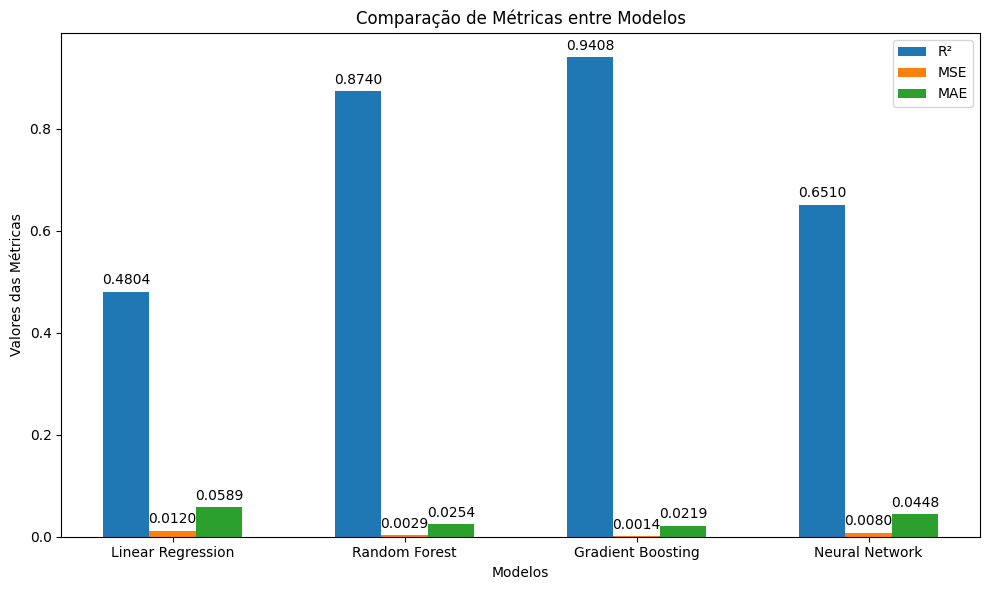

In [45]:
models = ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'Neural Network']

model_r2 = [lin_reg_best_r2, rf_reg_best_r2, gb_reg_best_r2, nn_best_r2]
model_mse = [lin_reg_best_mse, rf_reg_best_mse, gb_reg_best_mse, nn_best_mse]
model_mae = [lin_reg_best_mae, rf_reg_best_mae, gb_reg_best_mae, nn_best_mae]


x = np.arange(len(models))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))

bar1 = ax.bar(x - width, model_r2, width, label='R²')
bar2 = ax.bar(x, model_mse, width, label='MSE')
bar3 = ax.bar(x + width, model_mae, width, label='MAE')

ax.set_xlabel('Modelos')
ax.set_ylabel('Valores das Métricas')
ax.set_title('Comparação de Métricas entre Modelos')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # Offset vertical
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bar1)
add_labels(bar2)
add_labels(bar3)

plt.tight_layout()
plt.show()


<p align="justify">
Finalmente, aqui está um gráfico mostrando a progressão do preço em relação à quilometragem. Estão dispostos os valores dos labels, assim como os valores das predições de cada modelo.

In [46]:
X_test.sort_values(by='car_km', inplace=True)

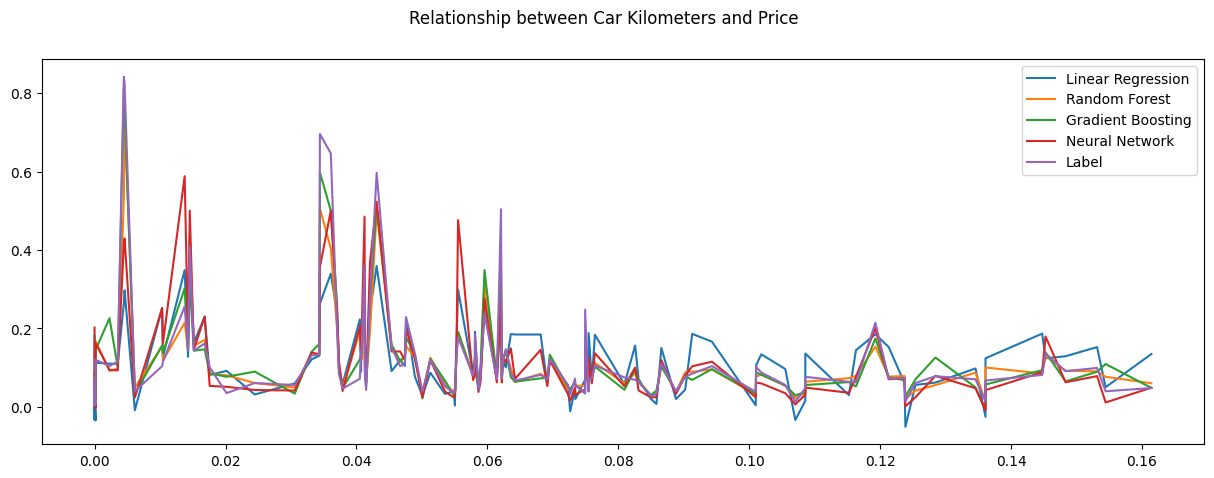

In [47]:
fig, ax = plt.subplots(figsize=(15, 5))

fig.suptitle('Relationship between Car Kilometers and Price')

ax.plot(X_test['car_km'], X_test['lin_reg_best_pred'], label='Linear Regression')
ax.plot(X_test['car_km'], X_test['rf_reg_best_pred'], label='Random Forest')
ax.plot(X_test['car_km'], X_test['gb_reg_best_pred'], label='Gradient Boosting')
ax.plot(X_test['car_km'], X_test['nn_reg_best_pred'], label='Neural Network')
ax.plot(X_test['car_km'], X_test['car_price'], label='Label')

plt.legend()
plt.show()

---

## Referêncais

Tratamento de Dados
- https://pypi.org/project/fancyimpute/#description

Modelos de Regressão
- [Linear Regression] https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
- [Random Forest Regressor] https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
- [Gradient Boosting Regressor] https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor
- [Neural Network Rsgressor] https://www.tensorflow.org/api_docs/python/tf/keras/Sequential
<br> <br>
- https://keras.io/examples/keras_recipes/reproducibility_recipes/
- https://keras.io/api/models/model_training_apis/

Registro de Treinamento
- [MLFlow] https://mlflow.org/
- https://mlflow.org/docs/latest/python_api/mlflow.sklearn.html
- https://mlflow.org/docs/latest/python_api/mlflow.tensorflow.html 

Otimização Automatizada
- [Optuna - A hyperparameter optimization framework] https://optuna.org/
- https://optuna.readthedocs.io/en/stable/

Leitura Adicional
- https://towardsdatascience.com/7-of-the-most-commonly-used-regression-algorithms-and-how-to-choose-the-right-one-fc3c8890f9e3
- https://towardsdatascience.com/sciem-an-order-of-operations-for-data-preprocessing-e3af0bf101b8